In [1]:
import numpy as np
from keras.layers import Input, Dense, Conv1D, AvgPool1D, MaxPool1D, Flatten, UpSampling1D, Reshape, BatchNormalization, LSTM, TimeDistributed
from keras.models import Model
from keras import regularizers
from keras.utils import to_categorical, print_summary
from keras.callbacks import CSVLogger
from sklearn.cluster import KMeans
from datasources import LoadMachineMonitoringData
from matplotlib import pyplot as plt

n_clusters = 5
n_features = 5

Using TensorFlow backend.


In [2]:
train, test, validate, meta = LoadMachineMonitoringData()
x_min = train.min(axis=(0, 1))
x_max = train.max(axis=(0, 1))
for channel_idx in range(x_min.size):
    train[:, :, channel_idx] = (train[:, :, channel_idx] - x_min[channel_idx]) / (x_max[channel_idx] - x_min[channel_idx])
    test[:, :, channel_idx] = (test[:, :, channel_idx] - x_min[channel_idx]) / (x_max[channel_idx] - x_min[channel_idx])
    validate[:, :, channel_idx] = (validate[:, :, channel_idx] - x_min[channel_idx]) / (x_max[channel_idx] - x_min[channel_idx])

In [3]:
kernel_l1 = 1e-4
kernel_l2 = 0
bias_l1 = 0
bias_l2 = 0
activation_l1 = 0
activation_l2 = 0

In [44]:
EncoderInputs = Input(shape=(train.shape[1], train.shape[2],))

RegularizerParams = {
    'kernel_regularizer': regularizers.l1_l2(kernel_l1, kernel_l2),
    'bias_regularizer': regularizers.l1_l2(bias_l1, bias_l2)
}

HiddenLayerParams = {
    'activation': 'relu',
    **RegularizerParams,
    'activity_regularizer': regularizers.l1_l2(activation_l1, activation_l2)
}

OutputLayerParams = {
    'activation': 'relu',
    **RegularizerParams
}

EncoderOutput = EncoderInputs
for idx in range(5):
    EncoderOutput = Conv1D(32, (7,), **HiddenLayerParams, padding='same')(EncoderOutput)
    EncoderOutput = AvgPool1D(2)(EncoderOutput)
# EncoderOutput = Dense(n_features, **HiddenLayerParams)(Flatten()(EncoderOutput))

EncoderModel = Model(inputs=EncoderInputs, outputs=EncoderOutput)
EncoderModel.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)
print_summary(EncoderModel)

# AutoEncoderOutput = Dense(EncoderModel.layers[-2].output_shape[1], **HiddenLayerParams)(EncoderOutput)
# AutoEncoderOutput = Reshape(EncoderModel.layers[-3].output_shape[1:3])(AutoEncoderOutput)
AutoEncoderOutput = EncoderOutput
for idx in range(5):
    AutoEncoderOutput = Conv1D(32, (7,), **HiddenLayerParams, padding='same')(AutoEncoderOutput)
    AutoEncoderOutput = UpSampling1D()(AutoEncoderOutput)
AutoEncoderOutput = Conv1D(17, (1,), **OutputLayerParams, padding='same')(AutoEncoderOutput)
    
AutoEncoderModel = Model(inputs=EncoderInputs, outputs=AutoEncoderOutput)
AutoEncoderModel.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)
print_summary(AutoEncoderModel)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 6000, 17)          0         
_________________________________________________________________
conv1d_160 (Conv1D)          (None, 6000, 32)          3840      
_________________________________________________________________
average_pooling1d_6 (Average (None, 3000, 32)          0         
_________________________________________________________________
conv1d_161 (Conv1D)          (None, 3000, 32)          7200      
_________________________________________________________________
average_pooling1d_7 (Average (None, 1500, 32)          0         
_________________________________________________________________
conv1d_162 (Conv1D)          (None, 1500, 32)          7200      
_________________________________________________________________
average_pooling1d_8 (Average (None, 750, 32)           0         
__________

In [45]:
ColOffset = (train.shape[1] - AutoEncoderModel.layers[-1].output_shape[1]) // 2
if ColOffset > 0:
    train_y = train[:, ColOffset:-ColOffset, :]
    test_y = test[:, ColOffset:-ColOffset, :]
    validate_y = validate[:, ColOffset:-ColOffset, :]
else:
    train_y = train
    test_y = test
    validate_y = validate
print(train_y.shape)
print(test_y.shape)
print(validate_y.shape)

(1239, 5984, 17)
(414, 5984, 17)
(552, 5984, 17)


In [46]:
log_file_name = 'example3_l1={:}_l2={:}_dense-act={:}_output-act={:}_features={:}_log.csv'.format(kernel_l1, kernel_l2, HiddenLayerParams['activation'], OutputLayerParams['activation'], n_features)
csv_logger = CSVLogger(log_file_name, append=False, separator=',')

In [47]:
AutoEncoderModel.fit(train, train_y, validation_data=(test, test_y), batch_size=64, epochs=200, callbacks=[csv_logger])

Train on 1239 samples, validate on 414 samples
Epoch 1/200
1239/1239 [==============================] - 112s 91ms/step - loss: 0.5846 - mean_squared_error: 0.2171 - val_loss: 0.5194 - val_mean_squared_error: 0.1996
Epoch 2/200
1239/1239 [==============================] - 4s 3ms/step - loss: 0.4701 - mean_squared_error: 0.1868 - val_loss: 0.4175 - val_mean_squared_error: 0.1746
Epoch 3/200
1239/1239 [==============================] - 4s 3ms/step - loss: 0.3858 - mean_squared_error: 0.1730 - val_loss: 0.3391 - val_mean_squared_error: 0.1584
Epoch 4/200
1239/1239 [==============================] - 4s 3ms/step - loss: 0.3127 - mean_squared_error: 0.1544 - val_loss: 0.2854 - val_mean_squared_error: 0.1509
Epoch 5/200
1239/1239 [==============================] - 4s 3ms/step - loss: 0.2606 - mean_squared_error: 0.1411 - val_loss: 0.2306 - val_mean_squared_error: 0.1255
Epoch 6/200
1239/1239 [==============================] - 4s 3ms/step - loss: 0.2245 - mean_squared_error: 0.1272 - val_loss: 

1239/1239 [==============================] - 4s 3ms/step - loss: 0.0148 - mean_squared_error: 0.0039 - val_loss: 0.0148 - val_mean_squared_error: 0.0040
Epoch 100/200
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0147 - mean_squared_error: 0.0040 - val_loss: 0.0148 - val_mean_squared_error: 0.0041
Epoch 101/200
1239/1239 [==============================] - 5s 4ms/step - loss: 0.0148 - mean_squared_error: 0.0041 - val_loss: 0.0147 - val_mean_squared_error: 0.0040
Epoch 102/200
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0146 - mean_squared_error: 0.0040 - val_loss: 0.0147 - val_mean_squared_error: 0.0042
Epoch 103/200
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0146 - mean_squared_error: 0.0041 - val_loss: 0.0144 - val_mean_squared_error: 0.0039
Epoch 104/200
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0144 - mean_squared_error: 0.0039 - val_loss: 0.0146 - val_mean_squared_error: 0.0042
Epoch 105/20

1239/1239 [==============================] - 4s 3ms/step - loss: 0.0102 - mean_squared_error: 0.0028 - val_loss: 0.0102 - val_mean_squared_error: 0.0028
Epoch 198/200
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0101 - mean_squared_error: 0.0028 - val_loss: 0.0103 - val_mean_squared_error: 0.0029
Epoch 199/200
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0102 - mean_squared_error: 0.0029 - val_loss: 0.0101 - val_mean_squared_error: 0.0028
Epoch 200/200
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0101 - mean_squared_error: 0.0028 - val_loss: 0.0102 - val_mean_squared_error: 0.0029


In [48]:
pred_validation_y = AutoEncoderModel.predict(validate)
print('Validation MSE: {:}'.format(np.mean((validate_y - pred_validation_y) ** 2)))

data = np.vstack([train, test, validate])
enc_data = EncoderModel.predict(data)
print(enc_data.shape)

reconstructed_data = AutoEncoderModel.predict(data)
print(reconstructed_data.shape)

Validation MSE: 0.0029103143606334925
(2205, 187, 32)
(2205, 5984, 17)


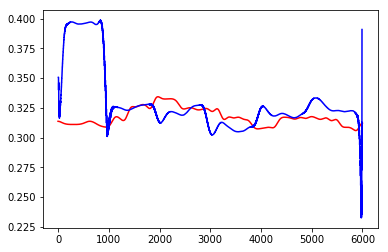

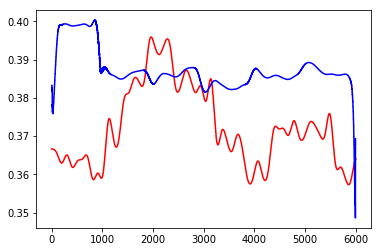

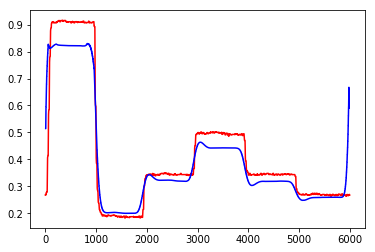

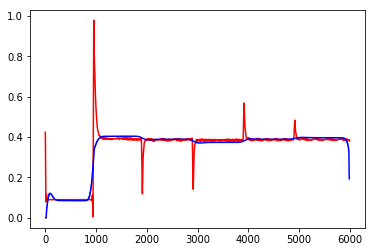

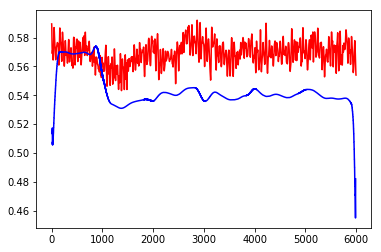

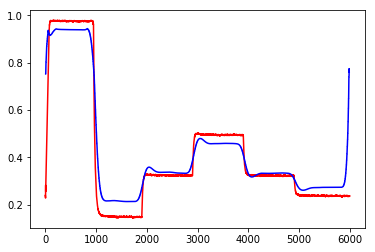

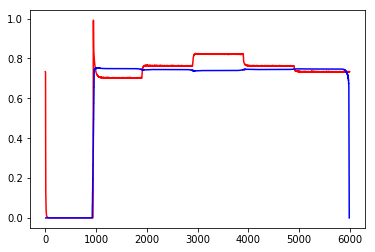

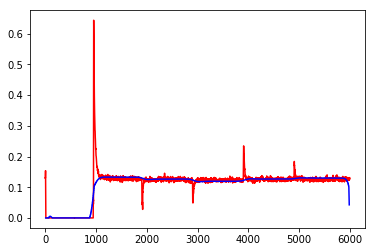

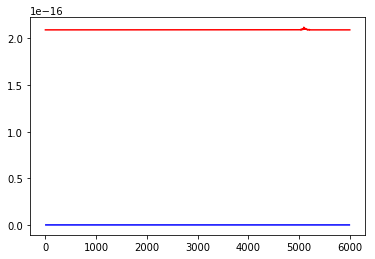

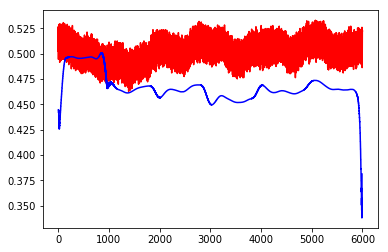

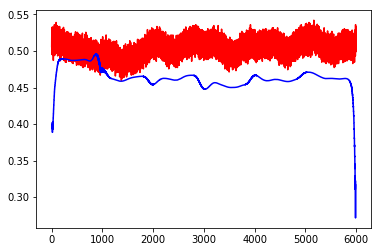

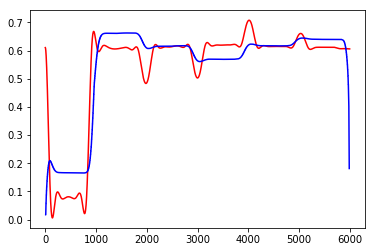

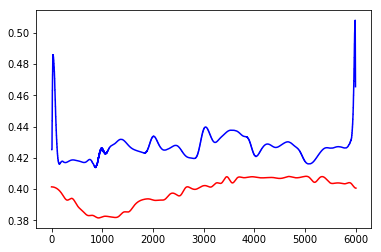

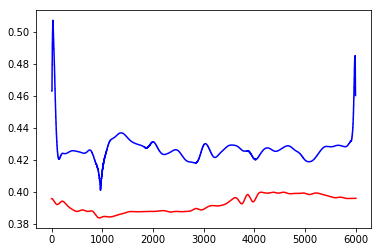

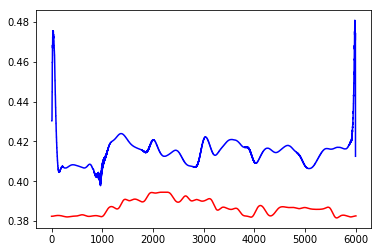

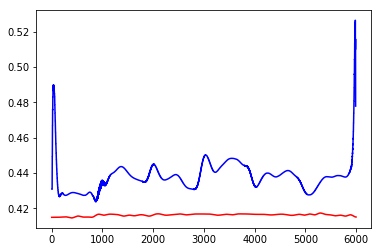

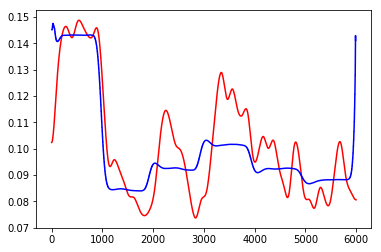

In [49]:
x_values = np.arange(data.shape[1])
x_values2 = np.arange(reconstructed_data.shape[1]) + (data.shape[1] - reconstructed_data.shape[1]) // 2
for idx in range(data.shape[2]):
    plt.figure()
    plt.plot(x_values, data[100, :, idx], 'r', x_values2, reconstructed_data[100, :, idx], 'b')
plt.show()